# Test Analyser

Read in the results data (from `data/results.csv` and analyse it. We use the [TAM](https://cran.r-project.org/web/packages/TAM/) package as it's capable of dealing with tests that have a mix of dichotomous and polytomous items. The goal here is to analyse a simulated test to ensure that it approximates a real world test.

We assume that the 1PL model is used.

$$
Pr(X=1) = \frac{exp(\theta-b)}{1 + exp(\theta-b)}
$$

We'll want to use the partial credit model (PCM) to analyse the data. Items are classed by the number of categories ($k$) that they contain; dichotomous items have a value of $k = 2, K = \{ 0, 1 \}$. The polytomous items have a varying number of categories.

I've found [chapter 4 of Introduction to Rasch Analysis in R](https://bookdown.org/dkatz/Rasch_Biome/polytomous-items.html) to be useful in understanding how to analyse polytomous tests using TAM.

## Data Ingest

For this analysis we need the `results.csv` file from the `data` folder.

In [6]:
library(tidyverse)
library(TAM)

dfRaw <- read_csv("data/results.csv")

dfTest <- dfRaw %>%
  dplyr::select(-systemname)

numItems <- ncol(dfTest)
numCandidates <- nrow(dfTest)


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  systemname = col_character()
)
ℹ Use `spec()` for the full column specifications.




In [7]:
###### show a selection of data from the test...
head(dfRaw[c('systemname','A1R#01_4445', 'A1R#02_7430', 'A1R#03_7657')])

systemname,A1R#01_4445,A1R#02_7430,A1R#03_7657
<chr>,<dbl>,<dbl>,<dbl>
DT0001,1,0,1
DT0002,1,1,1
DT0003,1,1,1
DT0004,1,0,1
DT0005,1,1,0
DT0006,1,1,1


## Summary Stats
We'll use the TAM package to get some summary info for the dataset. TAM will automatically run the PCM when our data is polytomous. We need to remove the systemname (candidate ID) column first.

In [8]:
dfTestResponses <- dfRaw[-c(1)]

In [9]:
pcm <- tam(dfTestResponses)

....................................................
Processing Data      2022-05-29 20:29:13 
    * Response Data: 5000 Persons and  62 Items 
    * Numerical integration with 21 nodes
    * Created Design Matrices   ( 2022-05-29 20:29:13 )
    * Calculated Sufficient Statistics   ( 2022-05-29 20:29:13 )
....................................................
Iteration 1     2022-05-29 20:29:13
E Step
M Step Intercepts   |----
  Deviance = 196271.4505
  Maximum item intercept parameter change: 0.802208
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.848906
....................................................
Iteration 2     2022-05-29 20:29:13
E Step
M Step Intercepts   |----
  Deviance = 189974.0401 | Absolute change: 6297.41 | Relative change: 0.03314879
  Maximum item intercept parameter change: 0.305036
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter

In [10]:
summary(pcm)

------------------------------------------------------------
TAM 3.7-16 (2021-06-24 14:31:37) 
R version 4.0.2 (2020-06-22) x86_64, darwin17.0 | nodename=tellurium.local | login=jamespage 

Date of Analysis: 2022-05-29 20:29:16 
Time difference of 2.605574 secs
Computation time: 2.605574 

Multidimensional Item Response Model in TAM 

IRT Model: 1PL
Call:
tam.mml(resp = resp)

------------------------------------------------------------
Number of iterations = 87 
Numeric integration with 21 integration points

Deviance = 188537.2 
Log likelihood = -94268.59 
Number of persons = 5000 
Number of persons used = 5000 
Number of items = 62 
Number of estimated parameters = 63 
    Item threshold parameters = 62 
    Item slope parameters = 0 
    Regression parameters = 0 
    Variance/covariance parameters = 1 

AIC = 188663  | penalty=126    | AIC=-2*LL + 2*p 
AIC3 = 188726  | penalty=189    | AIC3=-2*LL + 3*p 
BIC = 189074  | penalty=536.58    | BIC=-2*LL + log(n)*p 
aBIC = 188874  | pen

## Item Difficulties
We can extract the item difficulties and use them to update the item bank if we wish.

In [11]:
dfItemUpdates <- pcm$item

In [12]:
head(dfItemUpdates[, c('item', 'N', 'M', 'xsi.item')])

,item,N,M,xsi.item
,<chr>,<dbl>,<dbl>,<dbl>
A1R#01_4445,A1R#01_4445,5000,0.9520,-4.2650620
A1R#02_7430,A1R#02_7430,5000,0.5522,-0.3484386
A1R#03_7657,A1R#03_7657,5000,0.7562,-1.7668710
A2R#04_7816,A2R#04_7816,5000,0.4526,0.2850744
A2R#05_4435,A2R#05_4435,5000,0.4294,0.4344072
A2R#06_4023,A2R#06_4023,5000,0.2158,1.9944574


Here, `N` is the number of responses, `M` is the ratio of correct responses and `xsi.item` is the item difficulty (or $b$ parameter).

In [13]:
# read in items.csv and create a joined dataset using the new
# item difficulties calculated from the test response analysis
dfItems <- read_csv("data/items.csv") %>%
  select(-c(b, se)) %>%
  left_join(dfItemUpdates, by = c("UIID" = "item")) %>%
  select(c(UIID, a, b = xsi.item, rating, k))

# then write out to a new items file
write_csv(dfItems, 'data/updated-items.csv')


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  UIID = col_character(),
  a = col_double(),
  b = col_double(),
  se = col_double(),
  rating = col_character(),
  k = col_double()
)




### Polytomous Item Thresholds
Under the GRM or PCM polytomous IRT models, items are given a difficulty however, a set of thresholds $K$ is also required in order to fully describe the item. There must be $K-1$ thresholds (with threshold $k_0$ not being required to be supplied).

In [14]:
dfThresholds <- data.frame(tam.threshold(pcm))

In [15]:
(dfThresholds)

,Cat1
,<dbl>
A1R#01_4445,-4.2649841
A1R#02_7430,-0.3483582
A1R#03_7657,-1.7668762
A2R#04_7816,0.2850037
A2R#05_4435,0.4344177
A2R#06_4023,1.9944763
B1R#07_4444,0.8169250
B1R#08_7813,2.4712830
B1R#09_8136,1.2371521


In [16]:
write_csv(dfThresholds, 'data/item-thresholds.csv')

## Item Fit
We can calulcate the infit and outfit statistics. For polytomous items, the statistics are produced for each level.

In [17]:
Fit.poly <- tam.fit(pcm)

Item fit calculation based on 5 simulations
|**********|
|----------|


In [20]:
head(Fit.poly$itemfit)

,parameter,Outfit,Outfit_t,Outfit_p,Outfit_pholm,Infit,Infit_t,Infit_p,Infit_pholm
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A1R#01_4445,2.312358,17.9986665,1.995661e-72,1.217354e-70,1.0303189,0.5738040,0.5661005,1
2,A1R#02_7430,1.037193,2.1544998,3.120100e-02,6.864220e-01,1.0095954,0.5665137,0.5710446,1
3,A1R#03_7657,1.225557,9.9461368,2.621634e-23,1.520548e-21,0.9827132,-0.8211875,0.4115395,1
4,A2R#04_7816,1.003839,0.1949622,8.454225e-01,1.000000e+00,0.9921938,-0.4511043,0.6519144,1
5,A2R#05_4435,1.032595,1.8555719,6.351461e-02,1.000000e+00,1.0033537,0.1973359,0.8435647,1
6,A2R#06_4023,1.450979,17.1169054,1.110226e-65,6.661354e-64,1.0236555,1.0249009,0.3054100,1


## Item Information Functions
If we're interested we can get Item Characteristic Curves (ICCs) and Item Information Functions (IIFs) for the polytomous item thresholds. Here we'll show the ICCs and IIFs for items 1 and 2 in the test.

Iteration in WLE/MLE estimation  1   | Maximal change  1.4618 
Iteration in WLE/MLE estimation  2   | Maximal change  0.9286 
Iteration in WLE/MLE estimation  3   | Maximal change  0.482 
Iteration in WLE/MLE estimation  4   | Maximal change  0.0847 
Iteration in WLE/MLE estimation  5   | Maximal change  0.0046 
Iteration in WLE/MLE estimation  6   | Maximal change  4e-04 
Iteration in WLE/MLE estimation  7   | Maximal change  1e-04 
----
 WLE Reliability= 0.935 


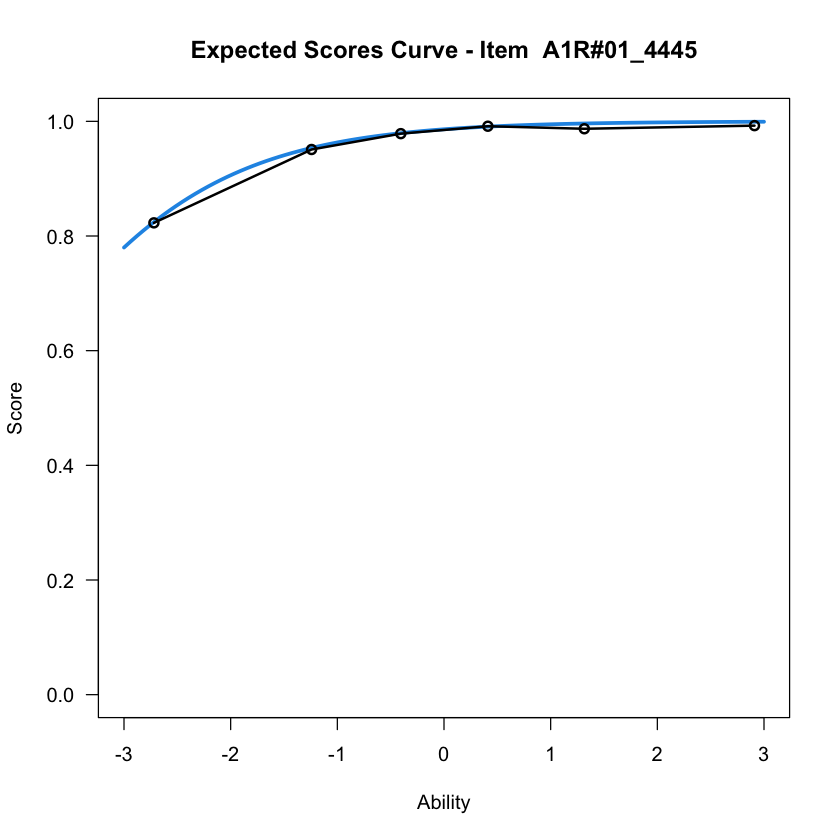

In [21]:
plot(pcm, items=1, type='expected', export=FALSE)

Iteration in WLE/MLE estimation  1   | Maximal change  1.4618 
Iteration in WLE/MLE estimation  2   | Maximal change  0.9286 
Iteration in WLE/MLE estimation  3   | Maximal change  0.482 
Iteration in WLE/MLE estimation  4   | Maximal change  0.0847 
Iteration in WLE/MLE estimation  5   | Maximal change  0.0046 
Iteration in WLE/MLE estimation  6   | Maximal change  4e-04 
Iteration in WLE/MLE estimation  7   | Maximal change  1e-04 
----
 WLE Reliability= 0.935 


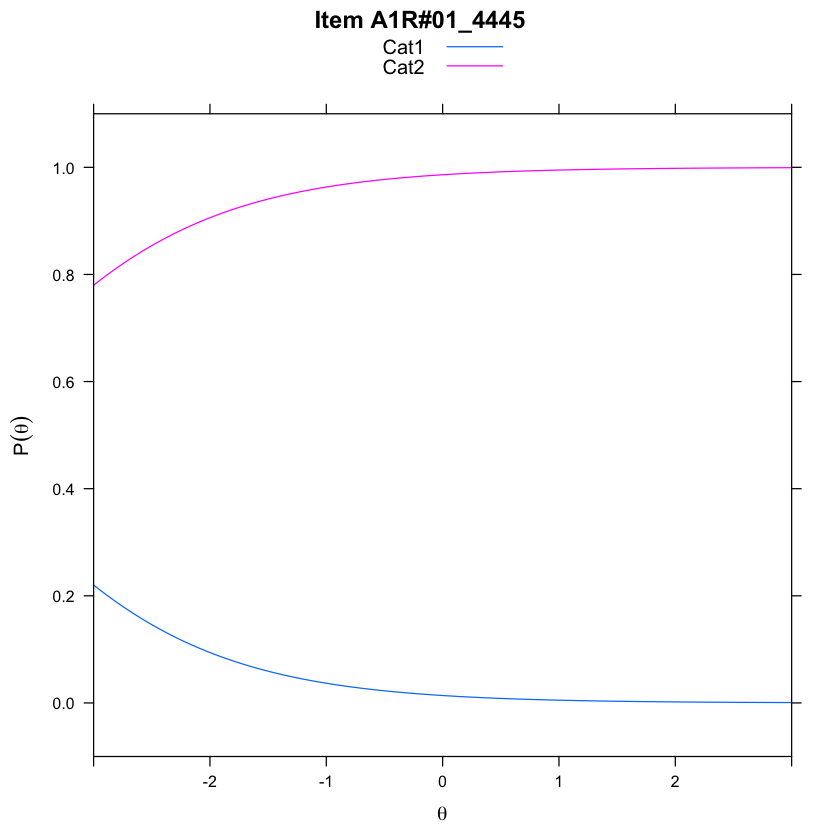

In [22]:
plot(pcm, items=1, type='items', export=FALSE)

Iteration in WLE/MLE estimation  1   | Maximal change  1.4618 
Iteration in WLE/MLE estimation  2   | Maximal change  0.9286 
Iteration in WLE/MLE estimation  3   | Maximal change  0.482 
Iteration in WLE/MLE estimation  4   | Maximal change  0.0847 
Iteration in WLE/MLE estimation  5   | Maximal change  0.0046 
Iteration in WLE/MLE estimation  6   | Maximal change  4e-04 
Iteration in WLE/MLE estimation  7   | Maximal change  1e-04 
----
 WLE Reliability= 0.935 


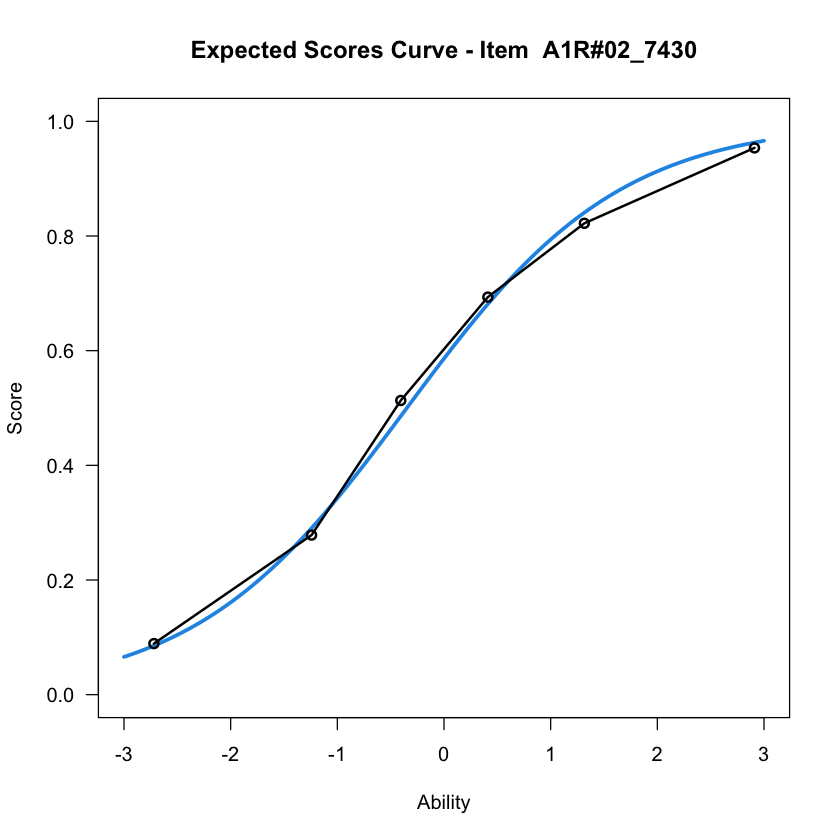

In [23]:
plot(pcm, items=2, type='expected', export=FALSE)

Iteration in WLE/MLE estimation  1   | Maximal change  1.4618 
Iteration in WLE/MLE estimation  2   | Maximal change  0.9286 
Iteration in WLE/MLE estimation  3   | Maximal change  0.482 
Iteration in WLE/MLE estimation  4   | Maximal change  0.0847 
Iteration in WLE/MLE estimation  5   | Maximal change  0.0046 
Iteration in WLE/MLE estimation  6   | Maximal change  4e-04 
Iteration in WLE/MLE estimation  7   | Maximal change  1e-04 
----
 WLE Reliability= 0.935 


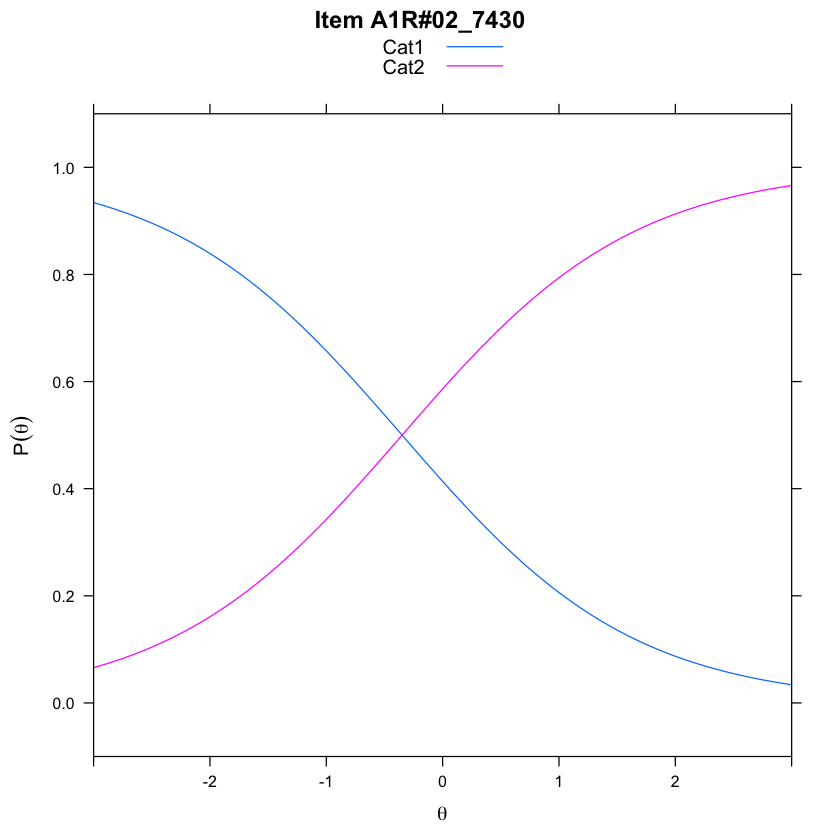

In [24]:
plot(pcm, items=2, type='items', export=FALSE)